# HSQL sums and spider plots

This notebook takes as input HQSL tables generated on Notebook 10c, produces statistical data and create plots.

## Import libraries

In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [1]:
import h3
def neighbour_mean(hex_id, hex_id_name, hex_bins, col_name):
    return hex_bins.loc[hex_bins[hex_id_name].isin(h3.k_ring(hex_id,1)),col_name].mean()

## Notebook config

In [234]:
walking_speed = 4.5
str_walking_speed = str(walking_speed).replace('.','_')
str_walking_speed

'4_5'

In [236]:
# Not running _priv educational equipments? (CHANGE PARAMETERS DICT)
pub = True

In [237]:
# Input - Processed HQSL
if pub:
    hex_processed_table = f'santiago_hexproximity_hqsl_{str_walking_speed}_kmh_pub'
else:
    hex_processed_table = f'santiago_hexproximity_hqsl_{str_walking_speed}_kmh'
# Output hexs resolution
res = 10
# Local dirs - 'alex' or 'edgar'
all_local_dirs = 'alex'

In [4]:
# --- REQUIRED DATA: parameters dictionary
# Structure: {social_functions:{themes:[source_names]}}

parameters_dict = {'supplying':{'groceries':['carniceria','hogar','local_mini_market',
                                             'bakeries','ferias','supermercado'],
                                'services':['centro_recyc'],
                               },
                   'caring':{'health':['clinica_priv','clinica_pub',
                                       'hospital_priv','hospital_pub',
                                       'vacunatorio_priv','vacunatorio_pub',
                                       'consult_ado_priv','consult_ado_pub',
                                       'salud_mental','labs_priv','residencia_adumayor','farmacia'],
                             'public_wellbeing':['bomberos'],
                             'exercise':['club_deportivo','eq_deportivo_pub','eq_deportivo_priv']
                            },
                   'living':{'errands_paperwork':['civic_office','tax_collection',
                                                  'social_security','correos','banco'],
                             'housing':['viv_count','viv_social_count'],
                             'public_services':['police'],
                             'fresh_air':['ep_plaza_small','ep_plaza_big'],
                             'temporary_residence':['hotel_count']
                            },
                   'enjoying':{'culture':['museos_priv','museos_pub','bibliotecas','sitios_historicos'],
                               'greenspace':['ndvi_count'],
                               'entertainment':['cines','librerias','restaurantes_bar_cafe']
                              },
                   'learning':{'education':['jardin_inf_pub',#'jardin_inf_priv',
                                            'edu_especial_pub',#'edu_especial_priv',
                                            'edu_basica_pub',#'edu_basica_priv',
                                            'edu_media_pub',#'edu_media_priv',
                                            'edu_tecnica','universidad',
                                            'edu_adultos_pub',#'edu_adultos_priv',
                                            'centro_edu_amb']
                              },
                   'working':{'workplaces':['oficinas_count'],
                              'sustainable_mobility':['ciclovias','paradas_tp',
                                                      'paradas_tp_tren','paradas_tp_metro']}
                  }

## Load data

### Load data - processed HQSL data

In [6]:
query = f'SELECT * FROM projects_research.{hex_processed_table} WHERE res = {res}'
hex_gdf = aup.gdf_from_query(query)

# Show
print(hex_gdf.shape)
print(hex_gdf.res.unique())
hex_gdf.head(2)

(63727, 201)
[10.]


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,culture_count,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",2.962535,4.001,6.049196,2.001,7.580963,2.001,50.542861,0.001,...,36.094867,7.988491,15.204718,22.882881,53.551171,24.218662,6.971818,28.120013,22.276371,133.583723
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,0.001,0.000000,0.001,0.000000,0.001,0.000000,0.001,...,0.000000,9.206629,0.000000,6.159570,0.000000,6.546095,0.000000,0.000000,5.215651,30.852563


### Load data - Load source matrix (summary base table)

In [7]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

In [8]:
df_summary = pd.read_csv(grl_dir + 'source_matrix_v240621.csv',sep=';',encoding='iso-8859-1') #encoding='iso-8859-1'
df_summary.rename(columns={df_summary.columns[0]: 'Function'},inplace=True, errors='raise')
df_summary

,Function,Theme,Variable,Source name
0,Supplies,GROCERIES,Butcher/Fish Shops,carniceria
1,Supplies,GROCERIES,Hardware/ Paint stores,hogar
2,Supplies,GROCERIES,Bakeries and delis,bakeries
3,Supplies,GROCERIES,Local and mini markets,local_mini_market
4,Supplies,GROCERIES,CIty fairs,ferias
5,Supplies,GROCERIES,Supermarkets,supermercado
6,Supplies,SERVICES,Recycling center,centro_recyc
7,Caring,HEALTH,Neighborhood clinics,clinica_priv
8,Caring,HEALTH,Neighborhood clinics,clinica_pub
9,Caring,HEALTH,Hospitals,hospital_priv


## Statistical summary

### Statistical summary - Data used in all statistical summaries

In [9]:
# Social function count columns
social_fn_cols = []

for k in parameters_dict.keys():
    social_fn_cols.append(k+'_count')

# Summary columns
summary_cols = social_fn_cols[:]
if 'hqsl' not in summary_cols:
    summary_cols.append('hqsl')

# Show
print(social_fn_cols)
print(summary_cols)

['supplying_count', 'caring_count', 'living_count', 'enjoying_count', 'learning_count', 'working_count']
['supplying_count', 'caring_count', 'living_count', 'enjoying_count', 'learning_count', 'working_count', 'hqsl']


## __All city__ data statistical summary

##### Statistical summary (__All city__)

In [10]:
hex_gdf[summary_cols].describe()

,supplying_count,caring_count,living_count,enjoying_count,learning_count,working_count,hqsl
count,63727.000000,63727.000000,63727.000000,63727.000000,63727.000000,63727.000000,63727.000000
mean,12.852586,6.145201,8.350689,7.498743,9.900164,9.614869,54.362252
std,9.653409,5.410393,6.044387,3.817063,8.338449,6.788923,36.337723
min,0.000000,0.000000,0.000000,1.273478,0.000000,0.000000,1.273478
25%,2.248224,0.499896,2.645092,4.631807,0.000000,3.789657,15.827849
50%,14.253406,5.853164,8.277403,6.409768,10.752870,10.266372,60.737841
75%,21.392444,9.686933,12.365938,9.462944,17.878157,14.560398,82.862548
max,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,160.571946


##### res value and res count by source name (__All city__)

In [11]:
df_summary['res_value'] = np.nan
df_summary['res_count'] = np.nan

for source in df_summary['Source name']:
    if pd.isna(source):
        continue
    for col in hex_gdf.columns:
        if source in col and 'scaled' in col:
            df_summary.loc[df_summary['Source name']==source, 'res_value'] = hex_gdf[col].mean()
        if source in col and '_count' in col and 'scaled' not in col:
            df_summary.loc[df_summary['Source name']==source, 'res_count'] = hex_gdf[col].mean()
df_summary

,Function,Theme,Variable,Source name,res_value,res_count
0,Supplies,GROCERIES,Butcher/Fish Shops,carniceria,3.171393,0.808073
1,Supplies,GROCERIES,Hardware/ Paint stores,hogar,3.045428,1.117260
2,Supplies,GROCERIES,Bakeries and delis,bakeries,3.698732,2.095055
3,Supplies,GROCERIES,Local and mini markets,local_mini_market,3.918096,3.655545
4,Supplies,GROCERIES,CIty fairs,ferias,4.099294,1.227393
5,Supplies,GROCERIES,Supermarkets,supermercado,3.682001,1.083146
6,Supplies,SERVICES,Recycling center,centro_recyc,4.562478,2.575696
7,Caring,HEALTH,Neighborhood clinics,clinica_priv,1.611419,0.524188
8,Caring,HEALTH,Neighborhood clinics,clinica_pub,3.139245,0.632527
9,Caring,HEALTH,Hospitals,hospital_priv,0.135802,0.015810


## __Spatial area__ statistical data summary

### Load data - Load areas of analysis

In [98]:
# SANTIAGO (AMS = Area Metropolitana de Santiago, Santiago's Metropolitan Area)
santiago_ams = gpd.read_file(grl_dir + 'zona_urbana_santiago.gpkg')
santiago_ams['name'] = 'ams'
santiago_ams = santiago_ams[['name','geometry']]
santiago_ams = santiago_ams.to_crs("EPSG:4326")

# COMUNAS
comuna_cerro_navia = gpd.read_file(grl_dir + 'comunas_cerro_navia.gpkg')
comuna_cerro_navia['name'] = 'comuna_cerro_navia'
comuna_cerro_navia = comuna_cerro_navia[['name','geometry']]
comuna_cerro_navia = comuna_cerro_navia.to_crs("EPSG:4326")

comuna_las_condes = gpd.read_file(grl_dir + 'comuna_las_condes.gpkg')
comuna_las_condes['name'] = 'comuna_las_condes'
comuna_las_condes = comuna_las_condes[['name','geometry']]
comuna_las_condes = comuna_las_condes.to_crs("EPSG:4326")

comuna_santiago = gpd.read_file(grl_dir + 'comunas_santiago.gpkg')
comuna_santiago['name'] = 'comuna_santiago'
comuna_santiago = comuna_santiago[['name','geometry']]
comuna_santiago = comuna_santiago.to_crs("EPSG:4326")

# ALAMEDA
if all_local_dirs == 'alex':
    alameda = gpd.read_file(grl_dir+"buffer_800m_nueva_alameda_32719.gpkg")
elif all_local_dirs == 'edgar':
    alameda = gpd.read_file(grl_dir + "buffer 800m nueva alameda.shp")
alameda['name'] = 'alameda'
alameda = alameda[['name','geometry']]
alameda = alameda.to_crs("EPSG:4326")

# ALAMEDA PONIENTE
alameda_poniente = gpd.read_file(grl_dir + 'alameda_poniente.gpkg')
alameda_poniente['name'] = 'alameda_poniente'
alameda_poniente = alameda_poniente[['name','geometry']]
alameda_poniente = alameda_poniente.to_crs("EPSG:4326")

# ALAMEDA ORIENTE
alameda_oriente = gpd.read_file(grl_dir + 'alameda_oriente.gpkg')
alameda_oriente['name'] = 'alameda_oriente'
alameda_oriente = alameda_oriente[['name','geometry']]
alameda_oriente = alameda_oriente.to_crs("EPSG:4326")

# UNIDADES VECINALES
unidades_vecinales = gpd.read_file(grl_dir + 'unidades_vecinales.gpkg')
unidades_vecinales['name'] = unidades_vecinales['COD_UNICO_']
unidades_vecinales = unidades_vecinales[['name','geometry']]
unidades_vecinales = unidades_vecinales.to_crs("EPSG:4326")

# [Other, not used as main analysis area of interest]
# UNIDADES VECINALES
all_unidades_vecinales = gpd.read_file(grl_dir + 'todas_unidades_vecinales.gpkg')
all_unidades_vecinales['name'] = all_unidades_vecinales['COD_UNICO_']
all_unidades_vecinales = all_unidades_vecinales[['name','geometry']]
all_unidades_vecinales = all_unidades_vecinales.to_crs("EPSG:4326")

# ALL AOI
#santiago_ams = aup.gdf_from_db('santiago_aoi','projects_research')
#santiago_ams['name'] = 'ams'
#santiago_ams = santiago_ams[['name','geometry']]

# SANTIAGO VIV
#santiago_viv = gpd.read_file(grl_dir + "viviendas_por_tipo_mnz_32719.gpkg")
#santiago_viv = santiago_viv.to_crs("EPSG:4326")

In [103]:
all_aoi_gdfs = [santiago_ams,comuna_cerro_navia,comuna_las_condes,comuna_santiago,alameda,alameda_poniente,alameda_oriente,unidades_vecinales]
aoi_all = pd.concat(all_aoi_gdfs,
                    ignore_index = True, axis = 0)
aoi_all

,name,geometry
0,ams,"MULTIPOLYGON (((-70.89696 -33.80372, -70.89668..."
1,comuna_cerro_navia,"MULTIPOLYGON (((-70.66314 -33.39923, -70.66400..."
2,comuna_las_condes,"MULTIPOLYGON (((-70.53235 -33.38217, -70.53235..."
3,comuna_santiago,"MULTIPOLYGON (((-70.65175 -33.43212, -70.64550..."
4,alameda,"MULTIPOLYGON (((-70.70775 -33.45031, -70.69297..."
5,alameda_poniente,"MULTIPOLYGON (((-70.67975 -33.44347, -70.67894..."
6,alameda_oriente,"MULTIPOLYGON (((-70.67894 -33.45865, -70.67975..."
7,13101_3,"MULTIPOLYGON (((-70.65649 -33.43082, -70.65647..."
8,13101_40,"MULTIPOLYGON (((-70.65156 -33.44447, -70.65151..."
9,13106_06,"MULTIPOLYGON (((-70.69219 -33.44799, -70.69221..."


### __Select area of interest manually!__

In [214]:
# ['ams','comuna_cerro_navia','comuna_las_condes','comuna_santiago','alameda','alameda_poniente','alameda_oriente','Unidades vecinales']
area = 'alameda_oriente'

In [233]:
# For unidades vecinales, intersect data
if area == 'Unidades vecinales':
    print(f"sjoining for Unidad vecinal {area}")
    uv_list = ['13101_3','13101_40','13106_06','13106_16','13106_22','13117_19']
    #ALL unidades vecinales:
    #uv_list = list(all_unidades_vecinales.name.unique())
    aoi = aoi_all.loc[aoi_all.name.isin(uv_list)].copy()
    hex_spatial = gpd.sjoin(hex_gdf, aoi)
    hex_spatial.drop(columns=['index_right'],inplace=True)

# For any other aoi, clip and keep hexs where at least 10% of the hex is inside area of interest
else:
    print(f"clipping for {area}")
    # Calculate hexs area
    hex_gdf['area_ha'] = hex_gdf.to_crs("EPSG:32719").area / 10000
    # Isolate area of interest
    aoi = aoi_all.loc[aoi_all.name==area].copy()

    # Get hexs area
    def clip_data(hex_gdf, aoi):
        # Clip hexagons to spatial area of interest
        hex_clip = gpd.clip(hex_gdf, aoi)
        # Keep hexs only if at least 10% of hex inside area of interest
        hex_clip['area_clip'] = hex_clip.to_crs("EPSG:32719").area / 10000
        hex_clip['area_pct'] = hex_clip['area_clip'] / hex_clip['area_ha']
        hex_clip = hex_clip.loc[hex_clip.area_pct>=0.1].copy()
        # Create gdf for current spatial area of interest
        hex_list = list(hex_clip.hex_id.unique())
        hex_spatial = hex_gdf.loc[hex_gdf.hex_id.isin(hex_list)].copy()
        return hex_spatial

    hex_spatial = clip_data(hex_gdf, aoi)
    hex_spatial['name'] = area

# Show
print(hex_spatial.shape)
hex_spatial.head(2)

clipping for alameda_oriente
(675, 203)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl,area_ha,name
85,8ab2c5541b57fff,"POLYGON ((-70.64424 -33.43552, -70.64487 -33.4...",3.921852,9.626000,4.518243,10.626,20.434179,0.001,12.512634,0.751,...,29.775491,29.077656,42.802228,19.357424,9.425618,29.863831,24.941028,147.716553,1.301034,alameda_oriente
303,8ab2c5541177fff,"POLYGON ((-70.65316 -33.43608, -70.65379 -33.4...",3.232028,12.834333,3.556783,11.001,23.060662,0.001,21.845564,0.001,...,29.695487,25.188186,47.734006,21.587834,10.000000,29.600649,25.138578,148.857360,1.301154,alameda_oriente


<Axes: >

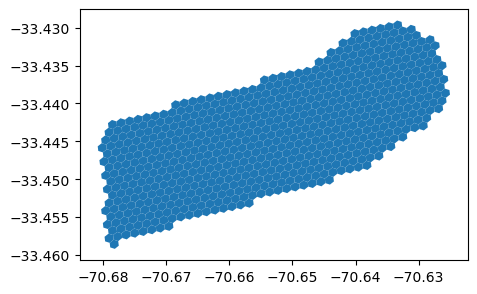

In [216]:
hex_spatial.plot()

In [217]:
aoi_summary = hex_spatial.copy()
# Calculate mean values for area of interest
aoi_summary = aoi_summary.drop(columns=['hex_id','geometry','city'])
aoi_summary = aoi_summary.groupby(['name']).mean()
aoi_summary.reset_index(inplace=True)
# Merge back to geometry
hex_new = pd.merge(aoi_all,aoi_summary,on='name',how = 'inner')
hex_new

,name,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl,area_ha
0,alameda_oriente,"MULTIPOLYGON (((-70.67894 -33.45865, -70.67975...",6.506031,5.155134,6.772637,7.452522,14.953508,0.630338,20.997799,0.417366,...,7.537803,21.972305,23.186658,48.940432,23.354669,6.999759,28.226758,23.539385,139.178795,1.300948


#### __Save result?__

In [219]:
save_result_to_db = False
save_local = True
if save_result_to_db:
    if pub:
        save_table = f'santiago_hqslsummary_{str_walking_speed}_kmh_pub'
    else:
        save_table = f'santiago_hqslsummary_{str_walking_speed}_kmh'
    aup.gdf_to_db_slow(hex_new, save_table, 'projects_research',if_exists='replace')
    
if save_local:
    if pub:
        hex_new.to_file(f'../../../output/data/santiago/hqslsummary_{str_walking_speed}_pub_{area_name}.gpkg')
    else:
        hex_new.to_file(f'../../../output/data/santiago/hqslsummary_{str_walking_speed}_all_{area_name}.gpkg')

### __For further analysis, if area = Unidades vecinales, select unidad vecinal of interest (area_name) manually!__

In [220]:
# unidades vecinales: ['13106_16', '13117_19', '13101_3', '13106_06', '13106_22', '13101_40']
unidad_vecinal = '13101_40'

In [221]:
if area == 'Unidades vecinales':
    area_name = unidad_vecinal
    hex_aoi = hex_spatial.loc[hex_spatial.name==unidad_vecinal].copy()
else:
    area_name = area
    hex_aoi = hex_spatial.copy()

##### Show statistical summary (__Selected spatial area only__)

In [222]:
hex_aoi[summary_cols].describe()

,supplying_count,caring_count,living_count,enjoying_count,learning_count,working_count,hqsl
count,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,26.727855,19.313772,23.056456,23.186658,23.354669,23.539385,139.178795
std,2.761554,4.085108,4.003542,4.304151,4.322526,2.904987,14.603346
min,9.576676,4.175251,7.454006,8.526422,8.214893,10.734562,49.546303
25%,25.539042,17.058716,20.247367,19.796291,19.494704,22.562005,133.183848
50%,27.660280,19.657921,23.181803,23.285285,23.165699,23.370837,142.340065
75%,28.343246,21.757884,26.027710,27.456481,27.843472,24.651167,148.534460
max,30.000000,29.865952,29.872346,30.000000,30.000000,30.000000,160.571946


##### Show res value by source name (__Selected spatial area only__)

In [223]:
spatial_area_df = df_summary.copy()

spatial_area_df['res_value'] = np.nan
spatial_area_df['res_value'] = np.nan

for source in spatial_area_df['Source name']:
    if pd.isna(source):
        continue
    for col in hex_aoi.columns:
        if source in col and 'scaled' in col:
            spatial_area_df.loc[df_summary['Source name']==source, 'res_value'] = hex_aoi[col].mean()
        if source in col and '_count' in col and 'scaled' not in col:
            spatial_area_df.loc[df_summary['Source name']==source, 'res_count'] = hex_aoi[col].mean()
spatial_area_df

,Function,Theme,Variable,Source name,res_value,res_count
0,Supplies,GROCERIES,Butcher/Fish Shops,carniceria,7.801767,2.405433
1,Supplies,GROCERIES,Hardware/ Paint stores,hogar,8.204714,8.965208
2,Supplies,GROCERIES,Bakeries and delis,bakeries,8.504922,18.578728
3,Supplies,GROCERIES,Local and mini markets,local_mini_market,8.639250,40.352864
4,Supplies,GROCERIES,CIty fairs,ferias,6.003296,1.164956
5,Supplies,GROCERIES,Supermarkets,supermercado,8.234260,5.155134
6,Supplies,SERVICES,Recycling center,centro_recyc,8.896495,13.749543
7,Caring,HEALTH,Neighborhood clinics,clinica_priv,7.733347,7.452522
8,Caring,HEALTH,Neighborhood clinics,clinica_pub,3.639944,0.630338
9,Caring,HEALTH,Hospitals,hospital_priv,3.142203,0.417366


#### __Save result?__

In [224]:
save_result = True
if save_result:
    if pub:
        spatial_area_df.to_csv(f'../../../output/data/santiago/source_matrix_res_{str_walking_speed}_pub_{area_name}.csv')
    else:
        spatial_area_df.to_csv(f'../../../output/data/santiago/source_matrix_res_{str_walking_speed}_all_{area_name}.csv')

## Polar plots (spatial area)

In [225]:
# WARNING: FOLDER CHANGES according to walking speed and _pub or _all. 
# Make sure directory exists
save_plots = True

In [226]:
import textwrap
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import math #importing the math functions
import matplotlib.pyplot as plt

In [227]:
pi = math.pi

In [228]:
def wrap_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=rotation, )

def make_spider(df, row, color, title, alpha, linewidth, zorder, max_graph_value, graph_div):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5), )
 
    ax = plt.subplot(1,1,1, polar=True, )
 
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
   
    plt.xticks(angles[:-1], categories, color='black', size=8,zorder=10)
    ax.tick_params(axis='x', rotation=0,pad=10, zorder=10)
    # ax.set_xlabel(labelpad=10)
    
    ax.set_rlabel_position(0)
    yticks = [i for i in range(0,max_graph_value+1, graph_div)]
    yticks_lab = [str(y) for y in yticks]
    plt.yticks(yticks, yticks_lab, color="black", size=10, zorder=10)
    plt.ylim(0,max_graph_value)
     
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=linewidth, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = alpha, zorder=zorder)
         
    wrap_labels(ax, 15, 0)
  
    # title = "Radar showing performance in each subject for "+ title
    # plt.title(title, fontsize=10, x = 0.5, y = 1.1)

### Spatial area polar plot - Shows all social functions

In [229]:
gdf_polar = hex_aoi[summary_cols].mean(axis=0)
gdf_polar

supplying_count     26.727855
caring_count        19.313772
living_count        23.056456
enjoying_count      23.186658
learning_count      23.354669
working_count       23.539385
hqsl               139.178795
dtype: float64

In [230]:
# Convert to df and pivot table
df = gdf_polar.copy()
df = pd.DataFrame(df).reset_index()
df.index = [0]*len(df)
df = df.rename(columns={'index':'social_fn',0:'value'})
df = df.pivot(columns='social_fn', values='value')
df

social_fn,caring_count,enjoying_count,hqsl,learning_count,living_count,supplying_count,working_count
0,19.313772,23.186658,139.178795,23.354669,23.056456,26.727855,23.539385


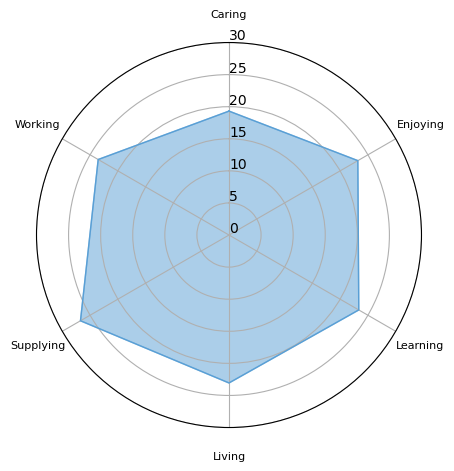

In [231]:
plt.figure()

# Convert 'sf_scaledcount names' to 'sf' for plot
df = df.rename(columns={'caring_count':'Caring',
                       'working_count':'Working',
                       'enjoying_count':'Enjoying',
                       'supplying_count':'Supplying',
                        'living_count':'Living',
                        'learning_count':'Learning'})
# Graph
color = '#599fd5'
make_spider(row=0, df = df.drop(columns='hqsl'), title = area_name, 
            color = color, alpha=0.5, linewidth=1, zorder=-1,
            max_graph_value = 30, graph_div = 5)

# Save
if save_plots:
    if pub:
        plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}_pub/SocialFunctions_{area_name}_all.svg')
    else:
        plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}_all/SocialFunctions_{area_name}_all.svg')

### Spatial area polar graph - Shows each social function's sources

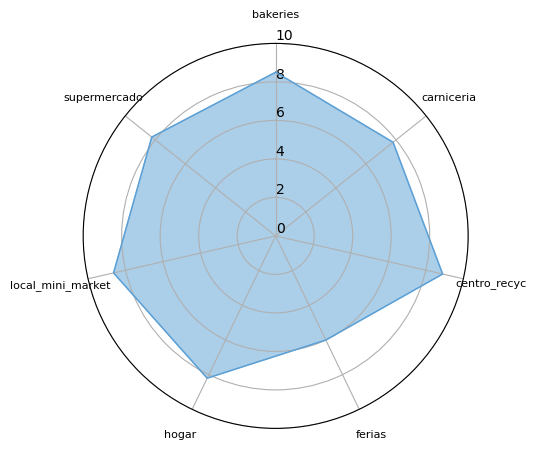

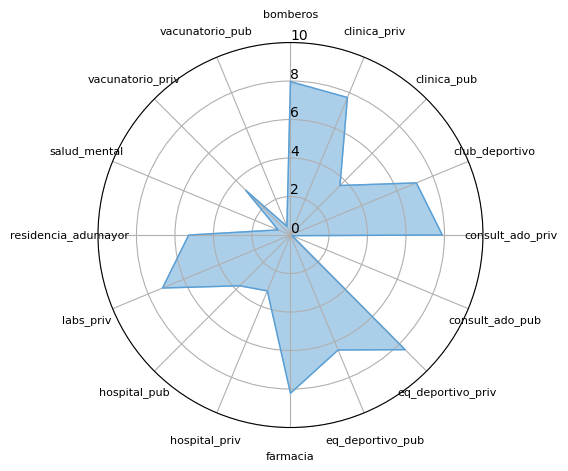

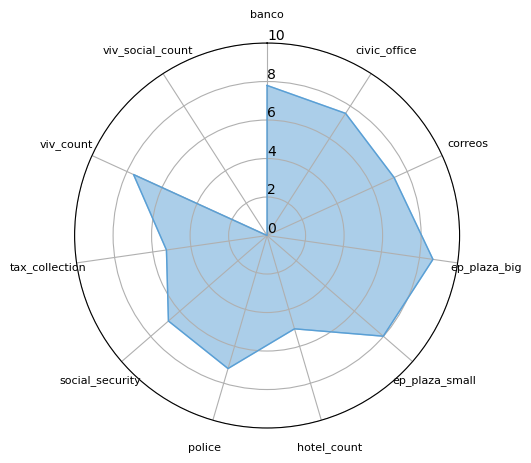

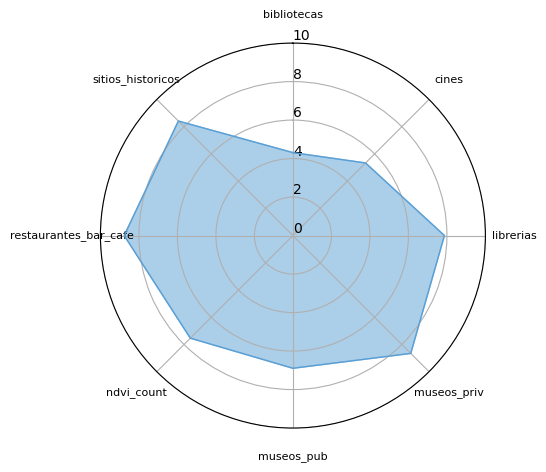

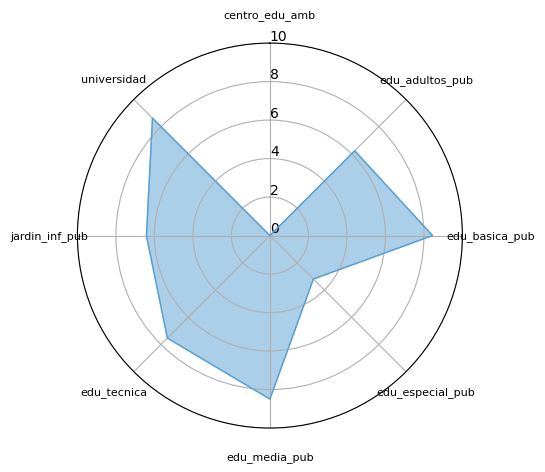

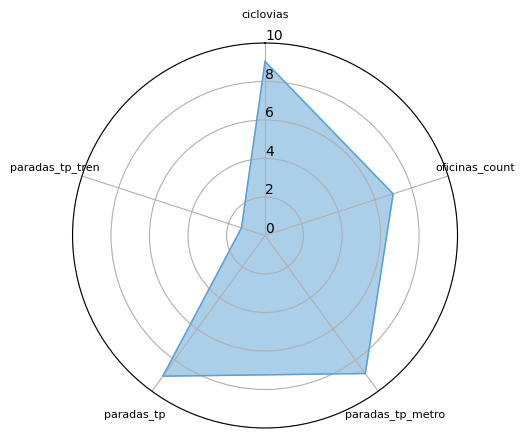

In [232]:
for social_fn_graph in social_fn_cols:
    plt.figure()

    # Convert social function 'sf_count_15min' name to 'sf_scaledcount' name
    if social_fn_graph == 'hqsl':
        continue
    social_fn_graph = social_fn_graph[:-6]
    metric_list = []
    for val in parameters_dict[social_fn_graph].values():
        for v in val:
            metric_list.append(v+'_scaledcount')

    # Get mean values for values of interest
    gdf_polar = hex_aoi[metric_list].mean(axis=0)

    # Convert to df and pivot table
    df = gdf_polar.copy()
    df = pd.DataFrame(df).reset_index()
    df.index = [0]*len(df)
    df = df.rename(columns={'index':social_fn_graph, 0:'value'})
    df = df.pivot(columns=social_fn_graph, values='value')

    # Convert 'metric_scaledcount names' to 'metric' for plot
    for val in parameters_dict[social_fn_graph].values():
        for v in val:
            df = df.rename(columns={v+'_scaledcount':v})

    # Graph
    make_spider(row=0, df = df, title = area, 
                color = color, alpha=0.5, linewidth=1, zorder=-1,
                max_graph_value = 10, graph_div = 2)

    # Save
    if save_plots:
        if pub:
            plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}_pub/SocialFunctions_{area_name}_{social_fn_graph}.svg')
        else:
            plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}_all/SocialFunctions_{area_name}_{social_fn_graph}.svg')